## Lab 2
### Part 2: Dealing with overfitting

Today we work with [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) (*hint: it is available in `torchvision`*).

Your goal for today:
1. Train a FC (fully-connected) network that achieves >= 0.885 test accuracy.
2. Cause considerable overfitting by modifying the network (e.g. increasing the number of network parameters and/or layers) and demonstrate in in the appropriate way (e.g. plot loss and accurasy on train and validation set w.r.t. network complexity).
3. Try to deal with overfitting (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

__Please, write a small report describing your ideas, tries and achieved results in the end of this file.__

*Note*: Tasks 2 and 3 are interrelated, in task 3 your goal is to make the network from task 2 less prone to overfitting. Task 1 is independent from 2 and 3.

*Note 2*: We recomment to use Google Colab or other machine with GPU acceleration.

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchsummary
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import os


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [ ]:
# Technical function
def mkdir(path):
    if not os.path.exists(root_path):
        os.mkdir(root_path)
        print('Directory', path, 'is created!')
    else:
        print('Directory', path, 'already exists!')
        
root_path = 'fmnist'
mkdir(root_path)

Directory fmnist is created!


In [ ]:
download = True
train_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()
transforms.Compose((transforms.ToTensor()))


fmnist_dataset_train = torchvision.datasets.FashionMNIST(root_path, 
                                                        train=True, 
                                                        transform=train_transform,
                                                        target_transform=None,
                                                        download=download)
fmnist_dataset_test = torchvision.datasets.FashionMNIST(root_path, 
                                                       train=False, 
                                                       transform=test_transform,
                                                       target_transform=None,
                                                       download=download)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting fmnist/FashionMNIST/raw/train-images-idx3-ubyte.gz to fmnist/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting fmnist/FashionMNIST/raw/train-labels-idx1-ubyte.gz to fmnist/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting fmnist/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to fmnist/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting fmnist/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to fmnist/FashionMNIST/raw



In [ ]:
train_loader = torch.utils.data.DataLoader(fmnist_dataset_train, 
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)
test_loader = torch.utils.data.DataLoader(fmnist_dataset_test,
                                          batch_size=256,
                                          shuffle=False,
                                          num_workers=2)

In [ ]:
len(fmnist_dataset_test)

10000

In [ ]:
for img, label in train_loader:
    print(img.shape)
#     print(img)
    print(label.shape)
    print(label.size(0))
    break

torch.Size([128, 1, 28, 28])
torch.Size([128])
128


### Task 1
Train a network that achieves $\geq 0.885$ test accuracy. It's fine to use only Linear (`nn.Linear`) layers and activations/dropout/batchnorm. Convolutional layers might be a great use, but we will meet them a bit later.

In [ ]:
class TinyNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, input_shape // 2),
            nn.ReLU(),
            nn.Linear(input_shape // 2, input_shape // 4),
            nn.ReLU(),
            nn.Linear(input_shape // 4, input_shape // 8),
            nn.ReLU(),
            nn.Linear(input_shape // 8, num_classes)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [ ]:
torchsummary.summary(TinyNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 392]         307,720
              ReLU-3                  [-1, 392]               0
            Linear-4                  [-1, 196]          77,028
              ReLU-5                  [-1, 196]               0
            Linear-6                   [-1, 98]          19,306
              ReLU-7                   [-1, 98]               0
            Linear-8                   [-1, 10]             990
Total params: 405,044
Trainable params: 405,044
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 1.55
Estimated Total Size (MB): 1.56
----------------------------------------------------------------


Your experiments come here:

In [ ]:
model = TinyNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3) # YOUR CODE HERE
loss_func = nn.CrossEntropyLoss() # YOUR CODE HERE

def fit(model, train_loader, val_loader, loss_fn, opt, n_epochs: int):
    train_loss = []
    train_accuracy = []
    val_loss = []
    val_accuracy = []

    
    for epoch in range(n_epochs):
        ep_train_loss = []
        ep_train_accuracy = []
        ep_val_loss = []
        ep_val_accuracy = []


        model.train(True) 
        for X_batch, y_batch in train_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            opt.zero_grad()
            preds = model(X_batch)
            y_pred = torch.argmax(preds, axis=1)
            ep_train_accuracy.append(torch.sum(y_pred==y_batch).item() / len(y_batch))
            loss = loss_fn(preds, y_batch)
            loss.backward()
            opt.step()
            ep_train_loss.append(loss.item())

        model.train(False) 
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)
                preds = model(X_batch)
                loss = loss_fn(preds, y_batch)
                ep_val_loss.append(loss.item())
                y_pred = torch.argmax(preds, axis=1)
                ep_val_accuracy.append(torch.sum(y_pred==y_batch).item() / len(y_batch))

        train_loss.append(np.mean(ep_train_loss))
        train_accuracy.append(np.mean(ep_train_accuracy))
        val_loss.append(np.mean(ep_val_loss))
        val_accuracy.append(np.mean(ep_val_accuracy))
        
        print(f"training loss: {train_loss[-1]:.6f}")
        print(f"training accuracy: {train_accuracy[-1]:.3f}")
        print(f"validation loss: {val_loss[-1]:.6f}")
        print(f"validation accuracy: {val_accuracy[-1]:.3f}")

    return train_loss, val_loss, train_accuracy, val_accuracy

# Your experiments, training and validation loops here
train_loss, val_loss, train_accuracy, val_accuracy = fit(model, train_loader, test_loader, loss_func, opt, 20)

training loss: 0.586232
training accuracy: 0.789
validation loss: 0.446197
validation accuracy: 0.840
training loss: 0.380110
training accuracy: 0.861
validation loss: 0.376154
validation accuracy: 0.862
training loss: 0.339154
training accuracy: 0.875
validation loss: 0.383719
validation accuracy: 0.861
training loss: 0.316974
training accuracy: 0.882
validation loss: 0.345670
validation accuracy: 0.876
training loss: 0.292581
training accuracy: 0.891
validation loss: 0.332547
validation accuracy: 0.882
training loss: 0.276692
training accuracy: 0.897
validation loss: 0.328787
validation accuracy: 0.883
training loss: 0.262800
training accuracy: 0.901
validation loss: 0.327425
validation accuracy: 0.883
training loss: 0.252270
training accuracy: 0.905
validation loss: 0.330748
validation accuracy: 0.880
training loss: 0.238583
training accuracy: 0.911
validation loss: 0.312237
validation accuracy: 0.888
training loss: 0.232931
training accuracy: 0.912
validation loss: 0.312903
validat

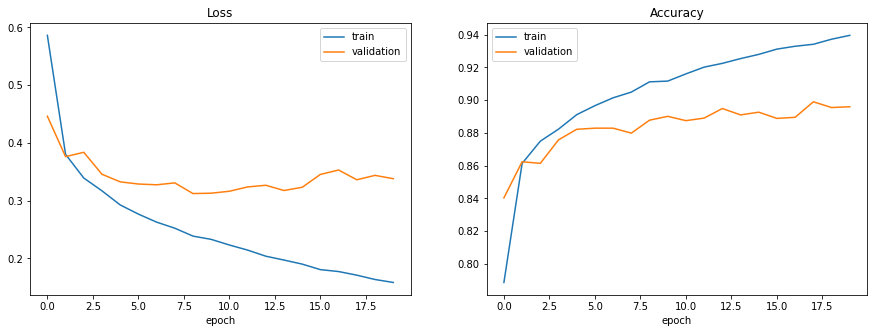

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].set_title('Loss')
axes[0].plot(train_loss, label='train')
axes[0].plot(val_loss, label='validation')
axes[0].set_xlabel('epoch')
axes[0].legend()

axes[1].set_title('Accuracy')
axes[1].plot(train_accuracy, label='train')
axes[1].plot(val_accuracy, label='validation')
axes[1].set_xlabel('epoch')
axes[1].legend()

In [ ]:
def test(model, test_loader):
    accuracy = []
    model.train(False) 
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            predictions = model(X_batch)
            y_pred = torch.argmax(predictions, axis=1)
            accuracy.append(torch.sum(y_pred==y_batch).item() / len(y_batch))
    return np.mean(accuracy)

In [ ]:
print("Test_accuracy = ", test(model, test_loader))

Test_accuracy =  0.89599609375


### Task 2: Overfit it.
Build a network that will overfit to this dataset. Demonstrate the overfitting in the appropriate way (e.g. plot loss and accurasy on train and test set w.r.t. network complexity).

*Note:* you also might decrease the size of `train` dataset to enforce the overfitting and speed up the computations.

In [ ]:
class OverfittingNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, input_shape * 2),
            nn.ReLU(),
            nn.Linear(input_shape * 2, input_shape // 2),
            nn.ReLU(),
            nn.Linear(input_shape // 2, input_shape // 8),
            nn.ReLU(),
            nn.Linear(input_shape // 8, input_shape // 16),
            nn.ReLU(),
            nn.Linear(input_shape // 16, num_classes)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [ ]:
indices = np.arange(20000)
train_dataset_decreased = torch.utils.data.Subset(fmnist_dataset_train, indices)
train_loader = torch.utils.data.DataLoader(train_dataset_decreased, 
                                           batch_size=256,
                                           shuffle=True,
                                           num_workers=2)

In [ ]:
torchsummary.summary(OverfittingNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                 [-1, 1568]       1,230,880
              ReLU-3                 [-1, 1568]               0
            Linear-4                  [-1, 392]         615,048
              ReLU-5                  [-1, 392]               0
            Linear-6                   [-1, 98]          38,514
              ReLU-7                   [-1, 98]               0
            Linear-8                   [-1, 49]           4,851
              ReLU-9                   [-1, 49]               0
           Linear-10                   [-1, 10]             500
Total params: 1,889,793
Trainable params: 1,889,793
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.04
Params size (MB): 7.21
Estimat

In [ ]:
indices = torch.arange(10000)
dataset_train_decr = torch.utils.data.Subset(fmnist_dataset_train, indices)

train_loader_decr = torch.utils.data.DataLoader(dataset_train_decr, 
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)

In [ ]:
model = OverfittingNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3) # YOUR CODE HERE
loss_func = nn.CrossEntropyLoss() # YOUR CODE HERE

# Your experiments, come here

train_loss, val_loss, train_accuracy, val_accuracy = fit(model, train_loader, test_loader, loss_func, opt, 50)


training loss: 0.960240
training accuracy: 0.647
validation loss: 0.625468
validation accuracy: 0.769
training loss: 0.532328
training accuracy: 0.806
validation loss: 0.598006
validation accuracy: 0.769
training loss: 0.446585
training accuracy: 0.840
validation loss: 0.499040
validation accuracy: 0.815
training loss: 0.408186
training accuracy: 0.853
validation loss: 0.448118
validation accuracy: 0.843
training loss: 0.368329
training accuracy: 0.866
validation loss: 0.414312
validation accuracy: 0.854
training loss: 0.348217
training accuracy: 0.872
validation loss: 0.389968
validation accuracy: 0.860
training loss: 0.324020
training accuracy: 0.882
validation loss: 0.434262
validation accuracy: 0.849
training loss: 0.316567
training accuracy: 0.883
validation loss: 0.388649
validation accuracy: 0.864
training loss: 0.290868
training accuracy: 0.891
validation loss: 0.432662
validation accuracy: 0.851
training loss: 0.286282
training accuracy: 0.894
validation loss: 0.389042
validat

In [ ]:
def plot_loss_acc(train_loss, val_loss, train_accuracy, val_accuracy):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    axes[0].set_title('Loss')
    axes[0].plot(train_loss, label='train')
    axes[0].plot(val_loss, label='validation')
    axes[0].set_xlabel('epoch')
    axes[0].legend()

    axes[1].set_title('Accuracy')
    axes[1].plot(train_accuracy, label='train')
    axes[1].plot(val_accuracy, label='validation')
    axes[1].set_xlabel('epoch')
    axes[1].legend()
    plt.show()

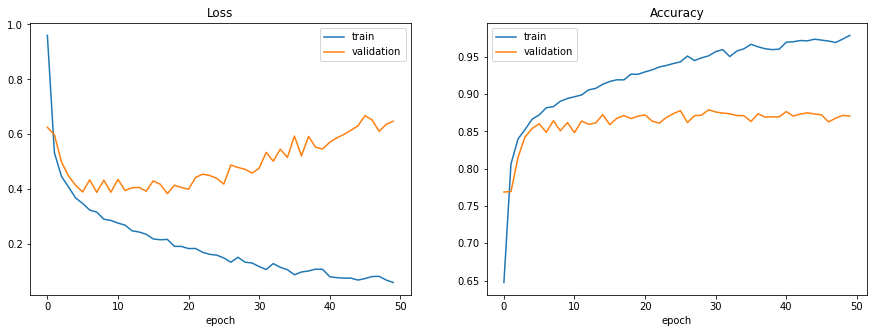

In [ ]:
plot_loss_acc(train_loss, val_loss, train_accuracy, val_accuracy)

### Task 3: Fix it.
Fix the overfitted network from the previous step (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results. 

In [ ]:
class FixedNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, 512),
            nn.ReLU(),
            nn.Linear(512, 258),
            nn.ReLU(),
            nn.Linear(258, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, num_classes)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [ ]:
torchsummary.summary(FixedNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 512]         401,920
              ReLU-3                  [-1, 512]               0
            Linear-4                  [-1, 258]         132,354
              ReLU-5                  [-1, 258]               0
            Linear-6                  [-1, 128]          33,152
              ReLU-7                  [-1, 128]               0
            Linear-8                   [-1, 64]           8,256
              ReLU-9                   [-1, 64]               0
           Linear-10                   [-1, 32]           2,080
             ReLU-11                   [-1, 32]               0
           Linear-12                   [-1, 16]             528
             ReLU-13                   [-1, 16]               0
           Linear-14                   

In [ ]:
model = FixedNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)# YOUR CODE HERE
loss_func = nn.CrossEntropyLoss()# YOUR CODE HERE

# Your experiments, come here
train_loss, val_loss, train_accuracy, val_accuracy = fit(model, train_loader, test_loader, loss_func, opt, 20)

training loss: 1.349115
training accuracy: 0.455
validation loss: 0.816868
validation accuracy: 0.644
training loss: 0.732989
training accuracy: 0.691
validation loss: 0.711814
validation accuracy: 0.735
training loss: 0.633111
training accuracy: 0.753
validation loss: 0.672610
validation accuracy: 0.737
training loss: 0.581519
training accuracy: 0.775
validation loss: 0.582461
validation accuracy: 0.781
training loss: 0.525466
training accuracy: 0.801
validation loss: 0.550902
validation accuracy: 0.787
training loss: 0.489426
training accuracy: 0.818
validation loss: 0.530817
validation accuracy: 0.801
training loss: 0.458883
training accuracy: 0.832
validation loss: 0.479781
validation accuracy: 0.827
training loss: 0.425098
training accuracy: 0.844
validation loss: 0.479476
validation accuracy: 0.832
training loss: 0.397639
training accuracy: 0.854
validation loss: 0.495798
validation accuracy: 0.820
training loss: 0.381729
training accuracy: 0.860
validation loss: 0.463938
validat

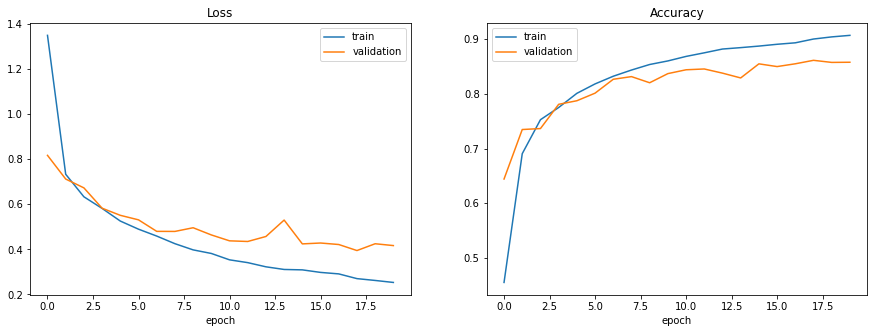

In [ ]:
plot_loss_acc(train_loss, val_loss, train_accuracy, val_accuracy)

In [ ]:
print("Test_accuracy = ", test(model, test_loader))

Test_accuracy =  0.85791015625


### Conclusions:
_Write down small report with your conclusions and your ideas._

All this laboratory work was built on the same network architecture, in the first paragraph the number of blocks was changed, in the second and third paragraphs, the parameters could only be changed or batchnorm and dropout could be added.
Without the help of batchnorm and dropout, we managed to achieve the required speed in the first task.
In the second task (after what I saw on the graphs in the first), it was not difficult to retrain.
In the third part, I was able to significantly reduce overfitting by just adding batchnorm and dropout.
I also note that a network with dropout, but without batchnorm, learns for a very long time, so it makes sense to use batchnorm and dropout together when possible.